In [1]:
!pip install tensorflow

Feature Matrix Sparsity: 0.0000


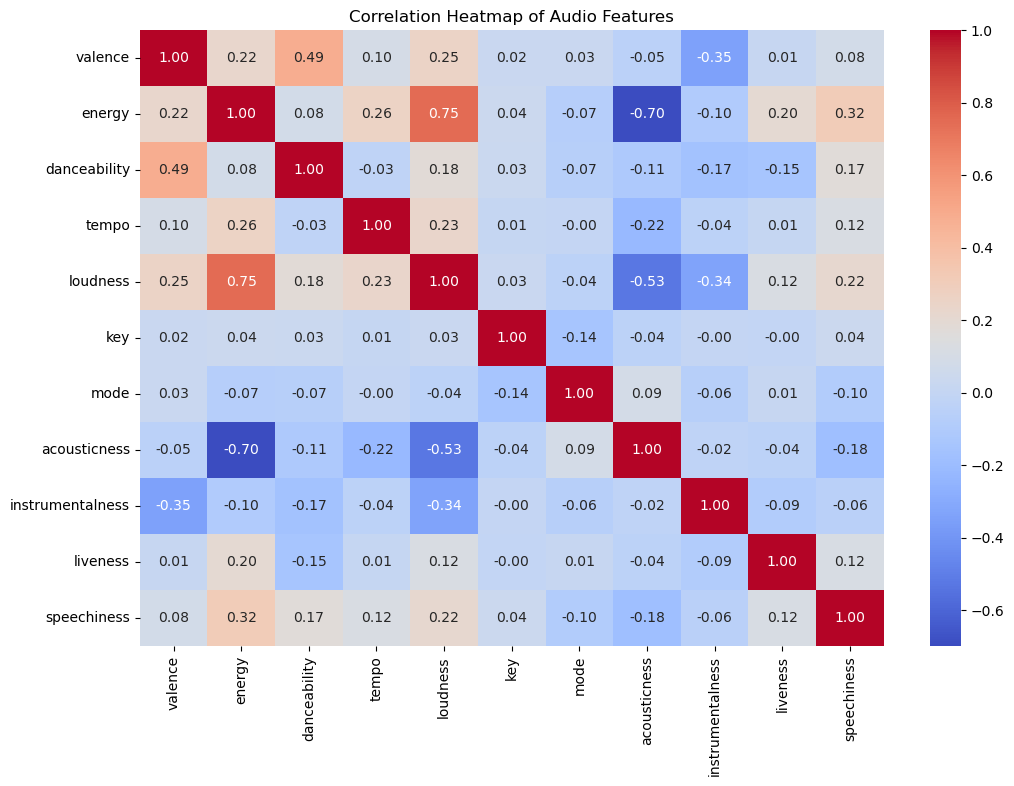

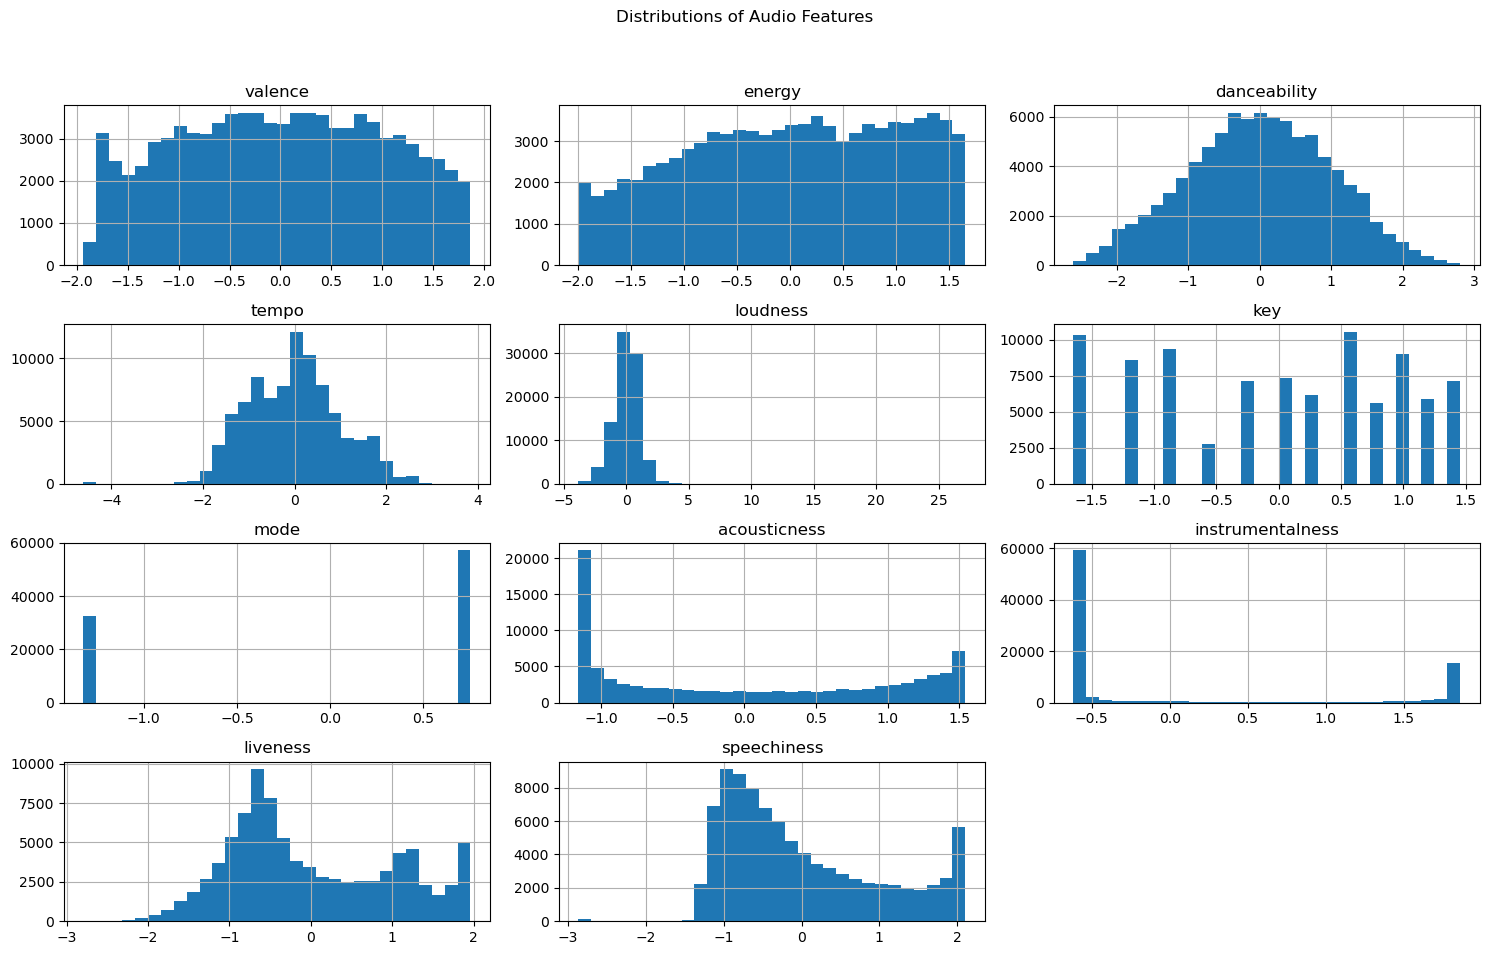

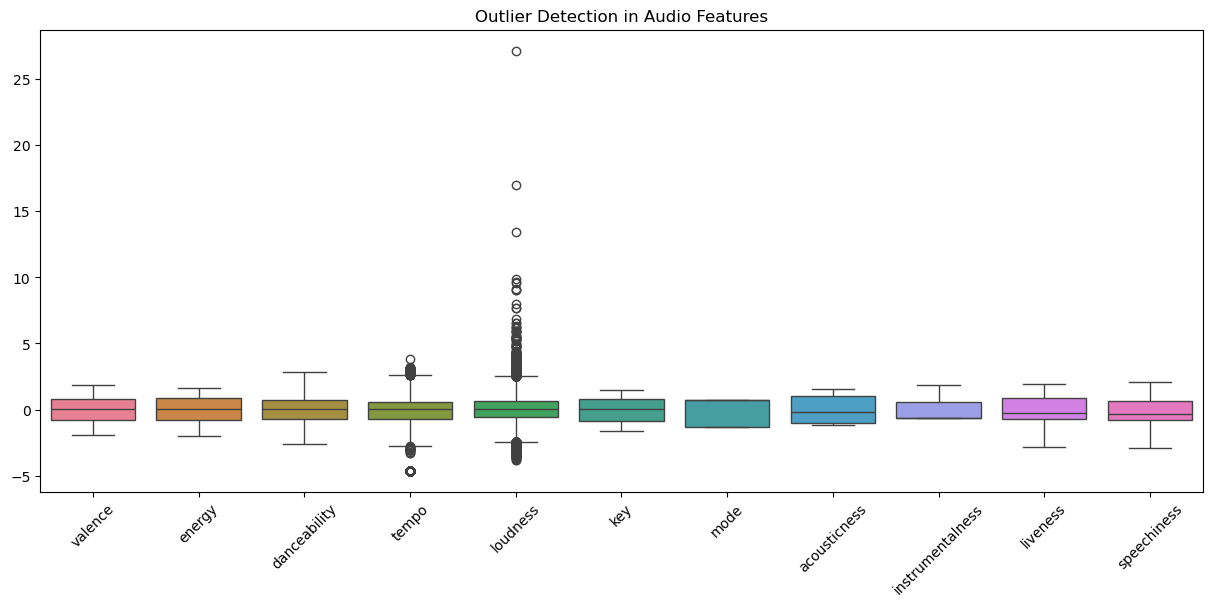

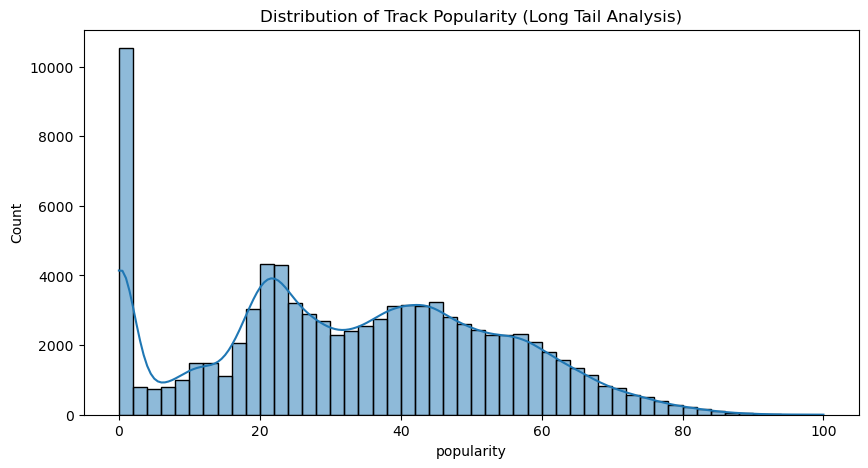

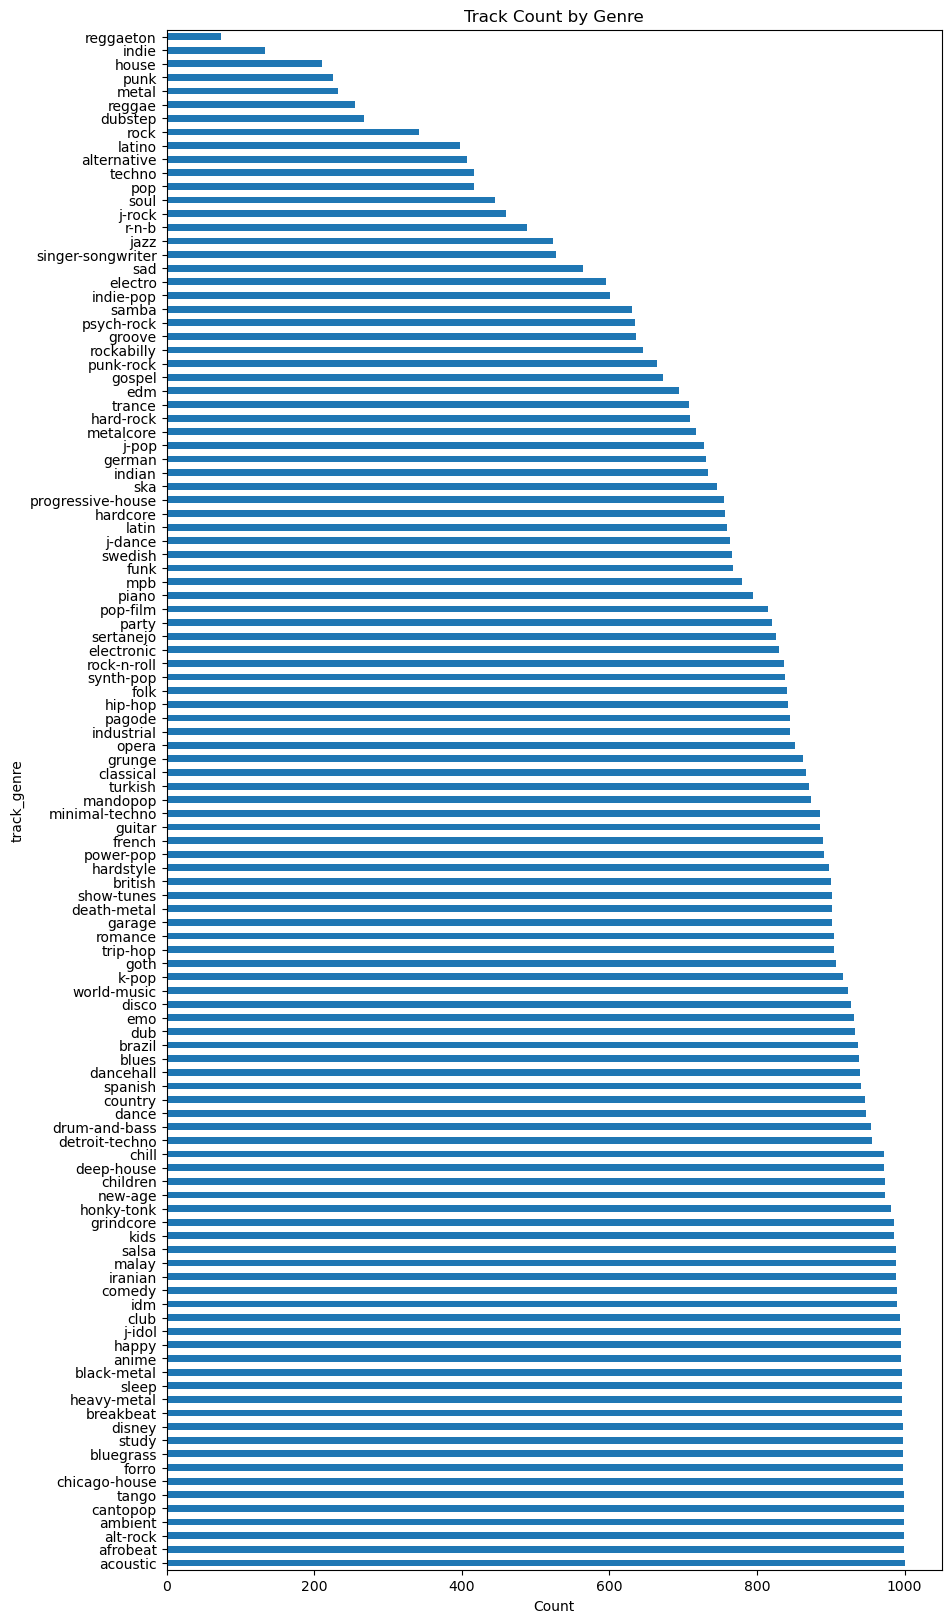


EDA Summary:
Total Unique Tracks: 89740
Features Prepped for Autoencoder: ['valence', 'energy', 'danceability', 'tempo', 'loudness', 'key', 'mode', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

# ===========================================================
# 1. DATA WRANGLING
# ===========================================================

# Load the Spotify Tracks Dataset
# Standardizing the variable name for consistent use throughout the project
df_spotify = pd.read_csv('dataset.csv')

# Drop the redundant index column if present (often found in Kaggle exports)
if 'Unnamed: 0' in df_spotify.columns:
    df_spotify.drop(columns=['Unnamed: 0'], inplace=True)

# Data Cleaning: Handling missing values and duplicates
df_spotify.dropna(inplace=True)
df_spotify.drop_duplicates(subset=['track_id'], inplace=True)

# Defining feature sets based on Capstone 3 Proposal [cite: 9, 10, 11]
mood_features = ['valence', 'energy', 'danceability']
prop_features = ['tempo', 'loudness', 'key', 'mode']
context_features = ['acousticness', 'instrumentalness', 'liveness', 'speechiness']
audio_features = mood_features + prop_features + context_features

# Specialized Wrangling: Handling varying scales 
# Implementing PowerTransformer to handle non-normal distributions (e.g., loudness)
pt = PowerTransformer(method='yeo-johnson')
df_spotify[audio_features] = pt.fit_transform(df_spotify[audio_features])

# Calculate Sparsity (Requirement for Recommendation Systems )
# In content-based filtering, we check for feature density
sparsity = 1.0 - (np.count_nonzero(df_spotify[audio_features]) / df_spotify[audio_features].size)
print(f"Feature Matrix Sparsity: {sparsity:.4f}")

# ===========================================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ===========================================================

# Relationship Investigation: Correlation Heatmap [cite: 50]
# Goal: Identify collinear features or relationships between audio attributes [cite: 44]
plt.figure(figsize=(12, 8))
sns.heatmap(df_spotify[audio_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Audio Features')
plt.show()

# Distribution Analysis: Histograms [cite: 48]
# Goal: Evaluate the distribution of key features after transformation [cite: 43]
df_spotify[audio_features].hist(bins=30, figsize=(15, 10))
plt.suptitle('Distributions of Audio Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Identifying Outliers: Box Plots 
# Goal: Check for sonic outliers that might skew the Autoencoder's latent space [cite: 16]
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_spotify[audio_features])
plt.title('Outlier Detection in Audio Features')
plt.xticks(rotation=45)
plt.show()

# Target Variable Balance: Popularity [cite: 42]
# Checking if popularity is balanced across the "Long Tail" [cite: 3]
plt.figure(figsize=(10, 5))
sns.histplot(df_spotify['popularity'], bins=50, kde=True)
plt.title('Distribution of Track Popularity (Long Tail Analysis)')
plt.show()

# Categorical Investigation: Genre Representation [cite: 12]
# Goal: Understand how many tracks exist per genre for later Clustering Analysis [cite: 19]
plt.figure(figsize=(10, 20))
df_spotify['track_genre'].value_counts().plot(kind='barh')
plt.title('Track Count by Genre')
plt.xlabel('Count')
plt.show()

# ===========================================================
# 3. SUMMARY FOR NEXT STEPS (MODELING)
# ===========================================================
print("\nEDA Summary:")
print(f"Total Unique Tracks: {df_spotify.shape[0]}")
print(f"Features Prepped for Autoencoder: {audio_features}")

Step 4 Complete: Data split and scaled. Processed CSV saved.
Model 1 (PCA Baseline) MSE: 0.0083
Model 2 (Simple Autoencoder) MSE: 0.0084
Model 3 (Deep Autoencoder) MSE: 0.0121
2805/2805 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


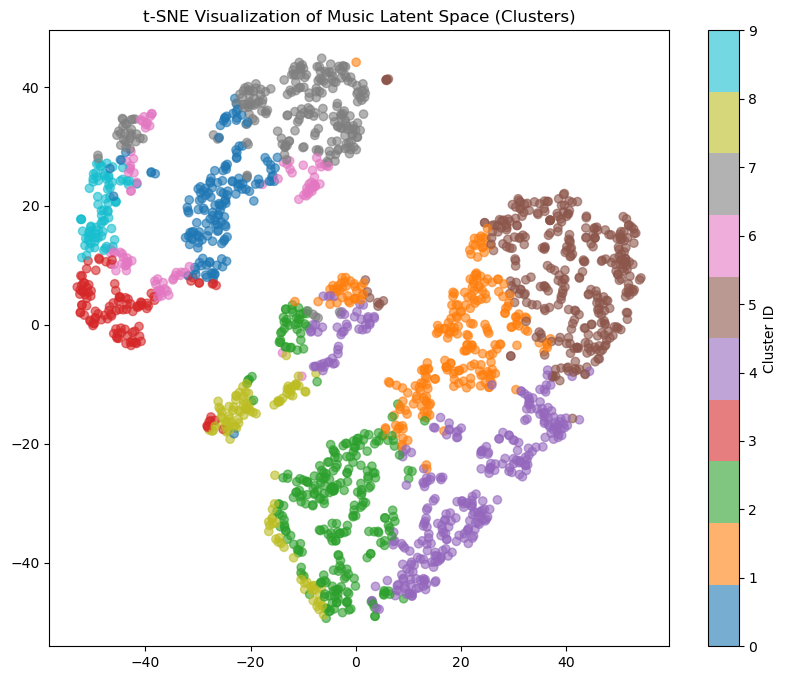


Recommendation Example for Track 0:
                                              track_name  \
34271                                        Baari Barsi   
21321                                     Sometimes Love   
67288                                               Easy   
21426                      Blessed (feat. Damian Marley)   
68836  Dile a Tu Gato (feat. Farruko & Franco El Gorila)   

                                                 artists track_genre  
34271  Salim–Sulaiman;Harshdeep Kaur;Labh Janjua;Amit...        folk  
21321                                      Apache Indian   dancehall  
67288                                             Jhayco       latin  
21426                               Wizkid;Damian Marley   dancehall  
68836                   Endo;Farruko;Franco "El Gorilla"      latino  


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras import layers, models

# ===========================================================
# STEP 4: PRE-PROCESSING & TRAINING DATA DEVELOPMENT
# ===========================================================

# 1. Feature Selection
# Consistent with EDA: using audio features for the 'DNA' of the song
audio_features = ['valence', 'energy', 'danceability', 'tempo', 'loudness', 
                  'key', 'mode', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']

# 2. Handling Categorical Data
# Creating dummy variables for 'track_genre' as required by Step 4 guidelines
# Note: We keep these separate to use audio features primarily for the Autoencoder
df_genre_dummies = pd.get_dummies(df_spotify['track_genre'], prefix='genre')
df_processed = pd.concat([df_spotify[audio_features], df_genre_dummies], axis=1)

# 3. Standardizing Numeric Magnitude
# While PowerTransformer was used in EDA, we use MinMaxScaler (0-1) here 
# as it is the 'Gold Standard' for Neural Network inputs (Autoencoders)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_spotify[audio_features])

# 4. Train-Test Split
# Splitting to evaluate the reconstruction error (unseen data performance)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Save the cleaned development dataset for future use
df_spotify.to_csv('spotify_cleaned_development.csv', index=False)
print("Step 4 Complete: Data split and scaled. Processed CSV saved.")

# ===========================================================
# STEP 5: MODELING
# ===========================================================

# --- MODEL 1: PCA (Baseline Dimensionality Reduction) ---
pca = PCA(n_components=6)
X_pca_train = pca.fit_transform(X_train)
pca_reconstruction = pca.inverse_transform(pca.transform(X_test))
pca_mse = np.mean(np.power(X_test - pca_reconstruction, 2))
print(f"Model 1 (PCA Baseline) MSE: {pca_mse:.4f}")

# --- MODEL 2: Simple Autoencoder (1 Hidden Layer) ---
input_dim = X_train.shape[1]
encoding_dim = 6 # Compressing 11 features into 6

simple_autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(encoding_dim, activation='relu'), # Encoder
    layers.Dense(input_dim, activation='sigmoid')  # Decoder
])

simple_autoencoder.compile(optimizer='adam', loss='mse')
simple_autoencoder.fit(X_train, X_train, epochs=20, batch_size=256, validation_data=(X_test, X_test), verbose=0)
simple_mse = simple_autoencoder.evaluate(X_test, X_test, verbose=0)
print(f"Model 2 (Simple Autoencoder) MSE: {simple_mse:.4f}")

# --- MODEL 3: Deep Autoencoder (Multi-Layer - PROPOSAL CORE) ---
# As per proposal: "Multi-Layer Neural Network to learn a condensed representation"
input_layer = layers.Input(shape=(input_dim,))
# Encoder Layers
encoded = layers.Dense(8, activation='relu')(input_layer)
encoded = layers.Dense(6, activation='relu')(encoded) # Latent Space / Bottleneck
# Decoder Layers
decoded = layers.Dense(8, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

deep_autoencoder = models.Model(input_layer, decoded)
encoder_model = models.Model(input_layer, encoded) # Extracting the 'Latent Space' model

deep_autoencoder.compile(optimizer='adam', loss='mse')
history = deep_autoencoder.fit(X_train, X_train, epochs=30, batch_size=256, 
                               validation_data=(X_test, X_test), verbose=0)
deep_mse = deep_autoencoder.evaluate(X_test, X_test, verbose=0)
print(f"Model 3 (Deep Autoencoder) MSE: {deep_mse:.4f}")

# ===========================================================
# RECOMMENDATION & CLUSTERING (Requirement Alignment)
# ===========================================================

# Final Choice: Model 3 (Deep Autoencoder) for lowest reconstruction error
# Generating the Latent Space for all tracks
latent_space = encoder_model.predict(X_scaled)

# 1. Similarity Search (Cosine Similarity)
# Function to recommend songs based on a track index
def get_recommendations(track_index, n=5):
    # Calculate similarity between the target song and all others in Latent Space
    similarity_scores = cosine_similarity([latent_space[track_index]], latent_space)[0]
    # Get indices of the most similar tracks (excluding itself)
    similar_indices = similarity_scores.argsort()[-n-1:-1][::-1]
    return df_spotify.iloc[similar_indices][['track_name', 'artists', 'track_genre']]

# 2. Clustering Analysis (K-Means)
# Finding clusters in the DNA of the music
kmeans = KMeans(n_clusters=10, random_state=42)
df_spotify['cluster'] = kmeans.fit_transform(latent_space).argmin(axis=1)

# 3. Visualization (t-SNE)
# Taking a sample for performance in the notebook visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(latent_space[:2000])

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_spotify['cluster'][:2000], cmap='tab10', alpha=0.6)
plt.title('t-SNE Visualization of Music Latent Space (Clusters)')
plt.colorbar(label='Cluster ID')
plt.show()

# Example Output
print("\nRecommendation Example for Track 0:")
print(get_recommendations(0))